In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})


/Users/archie/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
def distance(data):
    distances = pd.DataFrame()    
    # calculate distance in km between points
    data['dx'] = np.insert(sw.distance(data['Lon'].values, data['Lat'].values, 0),0,0)/1000
    data['x'] = np.cumsum(data['dx'])

    return data  

def bin(pgram, periods, bins, bin_mid):
    
    y = periods
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
          
    z = pgram # bead attribute

    digitized = np.digitize(y, bins)
    bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

    bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
    bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
    binned['var'] = bin_means
    binned['std'] = bin_std

    return binned


In [7]:
# import data

maxlon = 171
minlon = 139

Tok1 = pd.read_csv(r'/Users/archie/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
Tok1 = distance(Tok1)
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)].dropna().reset_index(drop = True)

Tok3 = pd.read_csv(r'/Users/archie/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
Tok3 = distance(Tok3)
Tok3 = Tok3[(Tok3['Lon']>minlon+5) & (Tok3['Lon']<maxlon+5)].dropna().reset_index(drop = True)

Tian = pd.read_csv(r'/Users/archie/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
Tian = distance(Tian)
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)].dropna().reset_index(drop = True)

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density', u'dx', u'x'],
      dtype='object')


(array([  1.09400000e+03,   0.00000000e+00,   2.30000000e+01,
          4.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   1.00000000e+00]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70, 80]),
 <a list of 8 Patch objects>)

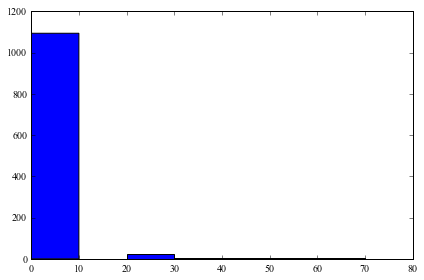

In [19]:
plt.hist(Tok1['dx'], [0,10,20,30,40,50,60,70,80])

number of segments =  9
for total  range
estimated slope for NCP =  -2.40088350698 , r =  -0.982787175567 , p-value < 0.05  True
estimated slope for T =  -3.14291382501 , r =  -0.970982602986 , p-value < 0.05  True
for 20 - 200km range
estimated slope for NCP =  -2.64641365819 , r =  -0.98357812782 , p-value < 0.05  True
estimated slope for T =  -2.69957455532 , r =  -0.980604487964 , p-value < 0.05  True
 
for 5 - 20km range
estimated slope for NCP =  -2.01551388037 , r =  -0.903086044697 , p-value < 0.05  True
estimated slope for T =  -4.06484258611 , r =  -0.95328351486 , p-value < 0.05  True


/Users/archie/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


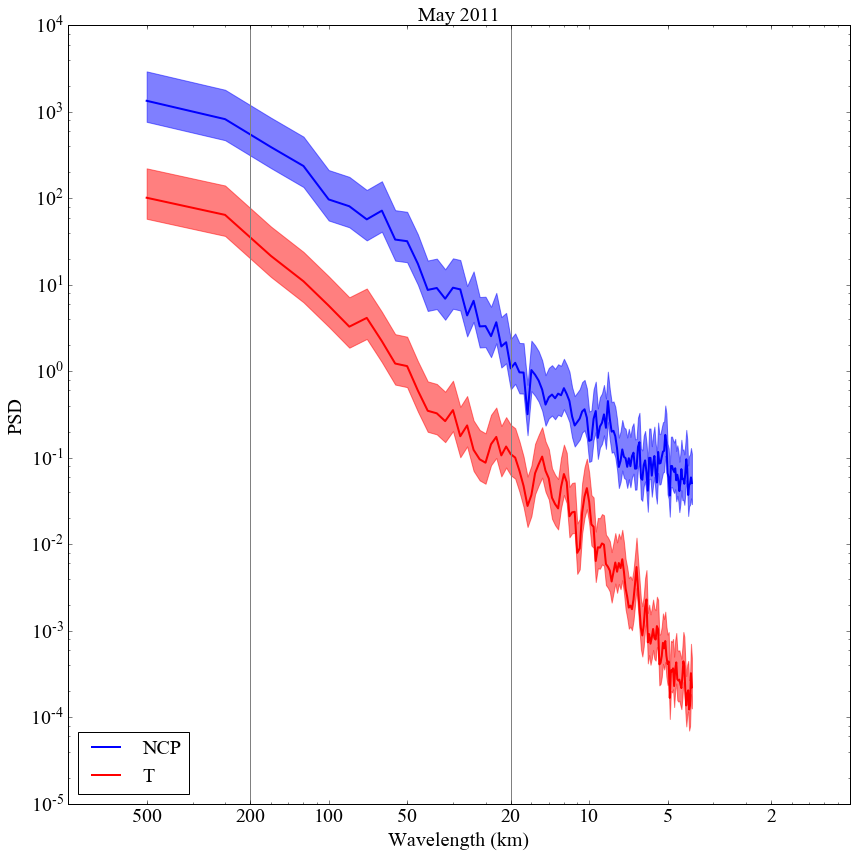

In [4]:
# FFT
M = 500;
dx = 2
# for Tokyo_1 cruise
N = np.max(Tok1['x'].values) - np.min(Tok1['x'].values)
n = 0
ll = 0
Tok1['nx'] = Tok1['x'] - np.min(Tok1['x'].values)

freq = np.fft.fftfreq(M/dx, d=dx)
pgram = np.zeros(len(freq))
pgramT = np.zeros(len(freq))

data_int = pd.DataFrame()

data_int['x'] = np.arange(Tok1['nx'][0], Tok1['nx'][len(Tok1)-1], dx)
data_int['NCP'] = np.interp(data_int['x'].values, Tok1['nx'], Tok1['Air-sea flux'])
data_int['T'] = np.interp(data_int['x'].values, Tok1['nx'], Tok1['T'])


while n < (N - M):
    
    data = data_int[(data_int['x']>=n) &(data_int['x']<(n+M))]
    # get linear trend
    m, c, rR, p, std_err = ss.linregress(data['x'], data['NCP'])
    trend = m*data['x'].values + c 
    det_data = data['NCP'].values-trend
    
    mT,cT, rR, p, std_err = ss.linregress(data['x'], data['T'])
    trendT = mT*data['x'].values + cT 
    det_dataT = data['T'].values-trendT


    pgram += np.abs(np.fft.fft((det_data)*np.hanning(len(det_data))))**2
    pgramT += np.abs(np.fft.fft((det_dataT)*np.hanning(len(det_dataT))))**2
    
    n += M/2
    ll += 1

pgram = (pgram/len(data_int)*2)[1:125]
pgramT = (pgramT/len(data_int)*2)[1:125]
freq = freq[1:125]

nu = 2*(ll)
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.plot(freq, pgram, 'b', lw=2, label='NCP')
plt.fill_between(freq, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(freq, pgramT, 'r', lw=2, label='T')
plt.fill_between(freq, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')


plt.title('May 2011',fontsize = 20)

print 'number of segments = ',ll

print 'for total  range'

m,c, r, p, std_err = ss.linregress(np.log10(freq),np.log10(pgram))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq),np.log10(pgramT))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05


print 'for 20 - 200km range'
yy = np.where((1/freq>=20) & (1/freq<=200))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

print ' '
print 'for 5 - 20km range'
yy = np.where((1/freq>=5) & (1/freq<=20))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

#fig1.savefig('../figures/NCP_T_FFT_May11.png', bbox_inches='tight', dpi=600)

T1_ncp = pgram
T1_t = pgramT
T1_err_low = err_low
T1_err_high = err_high

number of segments =  7
for total  range
estimated slope for NCP =  -1.43630080237 , r =  -0.949369099283 , p-value < 0.05  True
estimated slope for T =  -1.33190041502 , r =  -0.917430453625 , p-value < 0.05  True
for 20 - 200km range
estimated slope for NCP =  -2.0778251751 , r =  -0.970060893809 , p-value < 0.05  True
estimated slope for T =  -2.35077267368 , r =  -0.933242402005 , p-value < 0.05  True
 
for 5 - 20km range
estimated slope for NCP =  -0.899478576314 , r =  -0.680218939402 , p-value < 0.05  True
estimated slope for T =  -0.588586141165 , r =  -0.73395872799 , p-value < 0.05  True


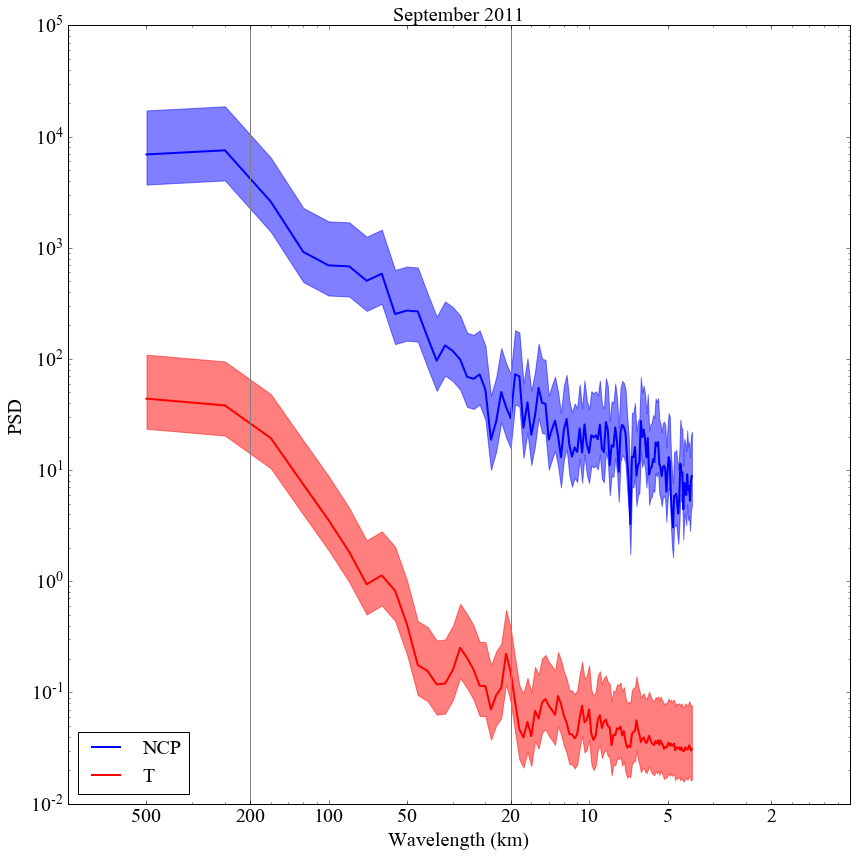

In [5]:
# FFT

# for Tokyo_3 cruise
N = np.max(Tok3['x'].values) - np.min(Tok3['x'].values)
n = 0
ll = 0
Tok3['nx'] = Tok3['x'] - np.min(Tok3['x'].values)

freq = np.fft.fftfreq(M/dx, d=dx)
pgram = np.zeros(len(freq))
pgramT = np.zeros(len(freq))

data_int = pd.DataFrame()

data_int['x'] = np.arange(Tok3['nx'][0], Tok3['nx'][len(Tok3)-1], dx)
data_int['NCP'] = np.interp(data_int['x'].values, Tok3['nx'], Tok3['Air-sea flux'])
data_int['T'] = np.interp(data_int['x'].values, Tok3['nx'], Tok3['T'])


while n < (N - M):
    
    data = data_int[(data_int['x']>=n) &(data_int['x']<(n+M))]
    # get linear trend
    m, c, rR, p, std_err = ss.linregress(data['x'], data['NCP'])
    trend = m*data['x'].values + c 
    det_data = data['NCP'].values-trend
    
    mT,cT, rR, p, std_err = ss.linregress(data['x'], data['T'])
    trendT = mT*data['x'].values + cT 
    det_dataT = data['T'].values-trendT


    pgram += np.abs(np.fft.fft((det_data)*np.hanning(len(det_data))))**2
    pgramT += np.abs(np.fft.fft((det_dataT)*np.hanning(len(det_dataT))))**2
    
    n += M/2
    ll += 1

pgram = (pgram/len(data_int)*2)[1:125]
pgramT = (pgramT/len(data_int)*2)[1:125]
freq = freq[1:125]

nu = 2*(ll)
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.plot(freq, pgram, 'b', lw=2, label='NCP')
plt.fill_between(freq, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(freq, pgramT, 'r', lw=2, label='T')
plt.fill_between(freq, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')


plt.title('September 2011',fontsize = 20)

print 'number of segments = ',ll

print 'for total  range'

m,c, r, p, std_err = ss.linregress(np.log10(freq),np.log10(pgram))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq),np.log10(pgramT))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05


print 'for 20 - 200km range'
yy = np.where((1/freq>=20) & (1/freq<=200))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

print ' '
print 'for 5 - 20km range'
yy = np.where((1/freq>=5) & (1/freq<=20))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05



plt.show()

#fig1.savefig('../figures/NCP_T_FFT_Sept11.png', bbox_inches='tight', dpi=600)

T3_ncp = pgram
T3_t = pgramT
T3_err_low = err_low
T3_err_high = err_high

number of segments =  7
for total  range
estimated slope for NCP =  -3.38163490298 , r =  -0.977336891759 , p-value < 0.05  True
estimated slope for T =  -2.4023205529 , r =  -0.97067078819 , p-value < 0.05  True
for 20 - 200km range
estimated slope for NCP =  -2.93814431839 , r =  -0.952435282893 , p-value < 0.05  True
estimated slope for T =  -2.52143443788 , r =  -0.968902191502 , p-value < 0.05  True
 
for 5 - 20km range
estimated slope for NCP =  -4.15946781656 , r =  -0.959828232096 , p-value < 0.05  True
estimated slope for T =  -2.85924392866 , r =  -0.922760059173 , p-value < 0.05  True


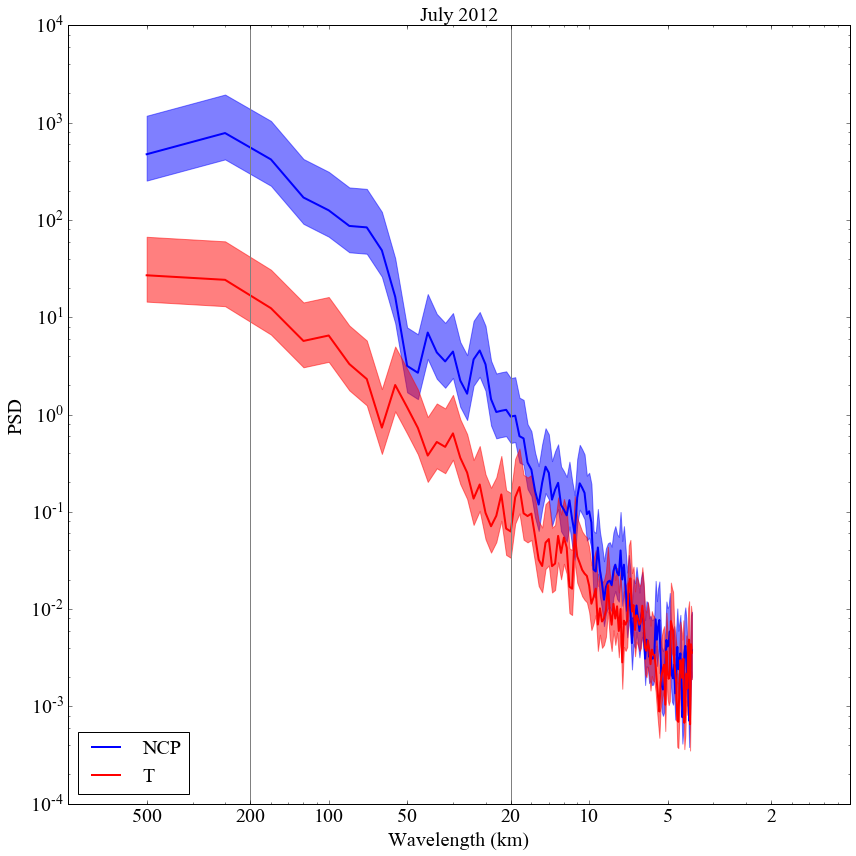

In [6]:
# FFT

# for Tokyo_3 cruise
N = np.max(Tian['x'].values) - np.min(Tian['x'].values)
n = 0
ll = 0
Tian['nx'] = Tian['x'] - np.min(Tian['x'].values)

freq = np.fft.fftfreq(M/dx, d=dx)
pgram = np.zeros(len(freq))
pgramT = np.zeros(len(freq))

data_int = pd.DataFrame()

data_int['x'] = np.arange(Tian['nx'][0], Tian['nx'][len(Tian)-1], dx)
data_int['NCP'] = np.interp(data_int['x'].values, Tian['nx'], Tian['Air-sea flux'])
data_int['T'] = np.interp(data_int['x'].values, Tian['nx'], Tian['T'])


while n < (N - M):
    
    data = data_int[(data_int['x']>=n) &(data_int['x']<(n+M))]
    # get linear trend
    m, c, rR, p, std_err = ss.linregress(data['x'], data['NCP'])
    trend = m*data['x'].values + c 
    det_data = data['NCP'].values-trend
    
    mT,cT, rR, p, std_err = ss.linregress(data['x'], data['T'])
    trendT = mT*data['x'].values + cT 
    det_dataT = data['T'].values-trendT


    pgram += np.abs(np.fft.fft((det_data)*np.hanning(len(det_data))))**2
    pgramT += np.abs(np.fft.fft((det_dataT)*np.hanning(len(det_dataT))))**2
    
    n += M/2
    ll += 1

pgram = (pgram/len(data_int)*2)[1:125]
pgramT = (pgramT/len(data_int)*2)[1:125]
freq = freq[1:125]

nu = 2*(ll)
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.plot(freq, pgram, 'b', lw=2, label='NCP')
plt.fill_between(freq, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(freq, pgramT, 'r', lw=2, label='T')
plt.fill_between(freq, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')


plt.title('July 2012',fontsize = 20)

print 'number of segments = ',ll

print 'for total  range'

m,c, r, p, std_err = ss.linregress(np.log10(freq),np.log10(pgram))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq),np.log10(pgramT))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

print 'for 20 - 200km range'
yy = np.where((1/freq>=20) & (1/freq<=200))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

print ' '
print 'for 5 - 20km range'
yy = np.where((1/freq>=5) & (1/freq<=20))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05



plt.show()

#fig1.savefig('../figures/NCP_T_FFT_July12.png', bbox_inches='tight', dpi=600)

Tn_ncp = pgram
Tn_t = pgramT
Tn_err_low = err_low
Tn_err_high = err_high

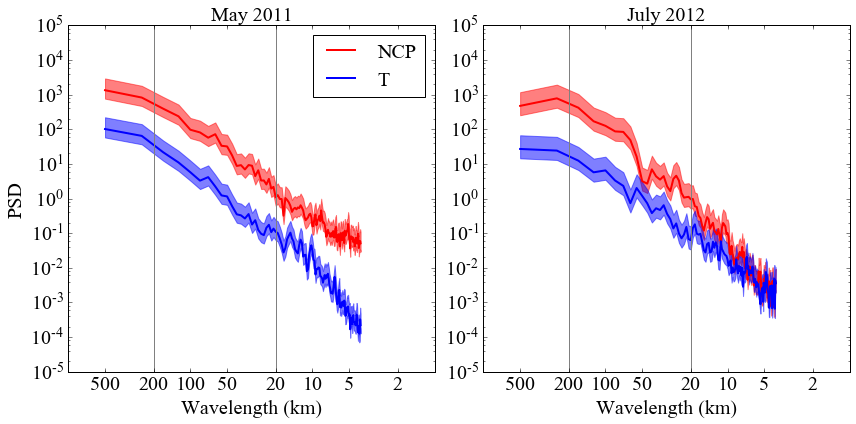

In [7]:
# fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), dpi = 300)
fig2, (ax1, ax3) = plt.subplots(1, 2, figsize = (12, 6), dpi = 300)

nn = 20

ax1.plot(freq, T1_ncp, 'r', lw=2, label='NCP')
ax1.fill_between(freq, T1_ncp*T1_err_low, T1_ncp*T1_err_high, color='r', alpha = 0.5)

ax1.plot(freq, T1_t, 'b', lw=2, label='T')
ax1.fill_between(freq, T1_t*T1_err_low, T1_t*T1_err_high, color='b', alpha = 0.5)

ax1.legend(loc = 'upper right', fontsize = nn)
ax1.tick_params(labelsize=nn)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([10**-5, 10**5])


ax1.set_ylabel('PSD', fontsize = nn)
ax1.set_xlabel('Wavelength (km)', fontsize = nn)
ax1.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

ax1.axvline(1./200, color = 'grey')
ax1.axvline(1./20, color = 'grey')
ax1.set_title('May 2011', fontsize = nn)
ax1.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]))
ax1.set_xticklabels([500, 200, 100, 50, 20, 10, 5, 2])

######################################################################################################################

# ax2.plot(freq, T3_ncp, 'b', lw=2, label='NCP')
# ax2.fill_between(freq, T3_ncp*T3_err_low, T3_ncp*T3_err_high, color='blue', alpha = 0.5)

# ax2.plot(freq, T3_t, 'r', lw=2, label='T')
# ax2.fill_between(freq, T3_t*T3_err_low, T3_t*T3_err_high, color='red', alpha = 0.5)

# ax2.tick_params(labelsize=16)

# ax2.set_yscale('log')
# ax2.set_xscale('log')
# ax2.set_ylim([10**-5, 10**5])

# ax2.set_xlabel('Wavelength (km)', fontsize = 16)
# ax2.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

# ax2.axvline(1./200, color = 'grey')
# ax2.axvline(1./20, color = 'grey')
# ax2.set_title('September 2011', fontsize = 16)
# ax2.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]))
# ax2.set_xticklabels([500, 200, 100, 50, 20, 10, 5, 2])

######################################################################################################################

ax3.plot(freq, Tn_ncp, 'r', lw=2, label='NCP')
ax3.fill_between(freq, Tn_ncp*Tn_err_low, Tn_ncp*Tn_err_high, color='r', alpha = 0.5)

ax3.plot(freq, Tn_t, 'b', lw=2, label='T')
ax3.fill_between(freq, Tn_t*Tn_err_low, Tn_t*Tn_err_high, color='b', alpha = 0.5)

ax3.tick_params(labelsize=nn)

ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim([10**-5, 10**5])


ax3.set_xlabel('Wavelength (km)', fontsize = nn)
ax3.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

ax3.axvline(1./200, color = 'grey')
ax3.axvline(1./20, color = 'grey')
ax3.set_title('July 2012', fontsize = nn)
ax3.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]))
ax3.set_xticklabels([500, 200, 100, 50, 20, 10, 5, 2])

plt.show()

fig2.savefig('../figures/NCP_T_FFT_MayJuly.png', dpi = 300)